In [11]:
import qutip
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

%matplotlib ipympl

In [12]:
font = {
        'weight' : 'bold',
        'size'   : 16}
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
plt.rc('font', **font)

In [13]:
# Physical parameters
omega = 1 # Energy hopping
g_0 = -3*omega
g_f = 3*omega
npart = int(60)
tau = int(120) # total time evolution
delta = omega

alpha_gvars = (64 * abs(delta)**2 * (np.sin(np.pi/npart))**2)**(-1)
beta_gvars = -2 * omega * np.cos(np.pi/npart)
def beta(g):
  if np.sign(g) < 0:
    return -2 * omega * np.cos(np.pi/npart)
  elif np.sign(g) > 0:
    return -2 * omega * np.cos(np.pi)
gamma_gvars = 2 * abs(delta) * np.sin(np.pi/npart)

gvars = {'alpha': alpha_gvars, 'beta1': beta(g_0), 'beta2': beta(g_f), 'gamma': gamma_gvars, 'tau': tau}
gvars_lin = {'gf': g_f, 'tau': tau}

temperature = 0.1 # Changes p_0
t_0 = 0
t_f = tau

# Formatting parameters
amt_times = 200 # How many points we calculate

ts = np.linspace(t_0, t_f, amt_times)

In [14]:
def g_t(t: float, gvars: dict):
    # Minimal action solution
    valaux = gvars['beta1'] + gvars['gamma'] * np.tan((1-2*t/gvars['tau']) * np.arctan((g_0 - gvars['beta1'])/gvars['gamma'])
                                                      + 2*t/gvars['tau'] * np.arctan((0 - gvars['beta1'])/gvars['gamma']) )
    if t >= gvars['tau']/2:
      t = t - gvars['tau']/2
      valaux = gvars['beta2'] + gvars['gamma'] * np.tan((1-2*t/gvars['tau']) * np.arctan((0 - gvars['beta2'])/gvars['gamma'])
                              + 2*t/gvars['tau'] * np.arctan((g_f - gvars['beta2'])/gvars['gamma']) )
    
    return valaux

In [15]:
def g_lin_t(t: float, gvars: dict):
    # Linear ramp solution
    return g_0 + (gvars['gf'] - g_0) * t / gvars['tau']

In [16]:
def H_k_func(k):
  array = np.array([[0,np.conjugate(2j * delta * np.sin(k))],[2j * delta * np.sin(k),0]])
  Hstatic = -2 * omega * np.cos(k) * qutip.sigmaz() - qutip.Qobj(array)
  Hdinamic = -qutip.sigmaz()
  H_k = [Hstatic, [Hdinamic, g_t]]
  return H_k

def H_k_lin_func(k):
  array = np.array([[0,np.conjugate(2j * delta * np.sin(k))],[2j * delta * np.sin(k),0]])
  Hstatic = -2 * omega * np.cos(k) * qutip.sigmaz() - qutip.Qobj(array)
  Hdinamic = -qutip.sigmaz()
  H_k = [Hstatic, [Hdinamic, g_lin_t]]
  return H_k

def H_k_t(t:float, k:float, gvars: dict):
  array = np.array([[0,np.conjugate(1j * delta * np.sin(k))],[1j * delta * np.sin(k),0]])
  Hstatic = -2 * omega * np.cos(k) * qutip.sigmaz() - 2 * qutip.Qobj(array)
  Hdinamic = -qutip.sigmaz()
  return Hstatic + Hdinamic * g_t(t, gvars)

def H_k_lin_t(t:float, k:float, gvars: dict):
  array = np.array([[0,np.conjugate(2j * delta * np.sin(k))],[2j * delta * np.sin(k),0]])
  Hstatic = -2 * omega * np.cos(k) * qutip.sigmaz() - qutip.Qobj(array)
  Hdinamic = -qutip.sigmaz()
  return Hstatic + Hdinamic * g_lin_t(t, gvars)

## Fidelity vs. $\tau$

In [17]:
tmin = 0.5
tmax = 120
amt_times = 200 # How many points we calculate
fidel_interval = np.linspace(tmin,tmax,amt_times)

In [18]:
fidel = []
fidel_lin = []

for i in fidel_interval:
    fidelval = 1
    fidelval_lin = 1

    for l in range(1, int(npart/2)+1):
        k = (2*l-1)*np.pi/npart
        tlistaux = np.linspace(t_0,i,10)

        gvarsaux = {'alpha': alpha_gvars, 'beta1': beta(g_0), 'beta2': beta(g_f), 'gamma': gamma_gvars, 'tau': i}
        gvars_linaux = {'gf': g_f, 'tau': i}

        H_k = H_k_func(k)
        H_k_lin = H_k_lin_func(k)

        gs_0 = H_k_t(t_0,k,gvarsaux).eigenstates()[1][0]
        gs_t = H_k_t(i,k,gvarsaux).eigenstates()[1][0]
        options = qutip.solver.Options(nsteps = 100000000, order=5)
        evol = qutip.mesolve(H_k, gs_0, tlistaux, [], [], args = gvarsaux, options = options).states

        gs_lin_0 = H_k_lin_t(0,k,gvars_linaux).eigenstates()[1][0]
        gs_lin_t = H_k_lin_t(i,k,gvars_linaux).eigenstates()[1][0]
        evol_lin = qutip.mesolve(H_k_lin, gs_lin_0, tlistaux, [], [], args = gvars_linaux).states

        fidelval *= np.linalg.norm(np.linalg.multi_dot([gs_t.dag(), evol[-1]]))
        fidelval_lin *= np.linalg.norm(np.linalg.multi_dot([gs_lin_t.dag(), evol_lin[-1]]))

    fidelval = fidelval**2
    fidelval_lin = fidelval_lin**2

    fidel += [fidelval]
    fidel_lin += [fidelval_lin]

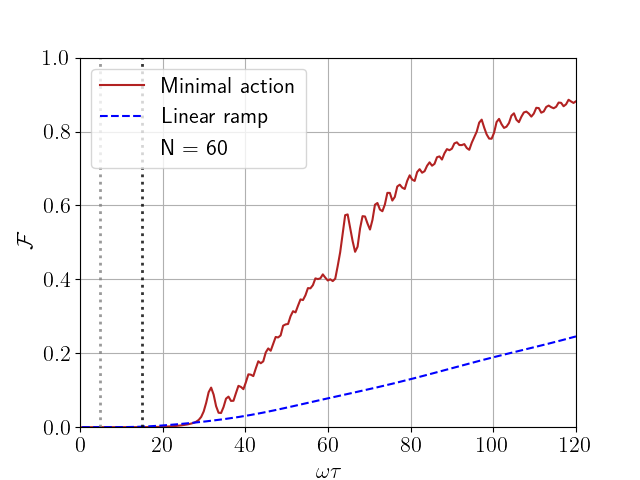

In [19]:
# Plot the results
fig, ax = plt.subplots()

# Plot the results for linear ramp and action ramp
ax.plot(fidel_interval, fidel, color='firebrick', label='Minimal action')
ax.plot(fidel_interval, fidel_lin, color='blue', linestyle='dashed', label='Linear ramp')
ax.plot([],[],label='N = {}'.format(npart), alpha=0.0)

# Add vertical lines at specific points
ax.axvline(x=1 / (4 * np.sin(np.pi / npart)), color='gray', linestyle='dotted', linewidth=2, alpha=0.8)
ax.axvline(x=npart / 4, color='black', linestyle='dotted', linewidth=2, alpha=0.8)

# Add labels and grid
ax.set_xlabel(r'$\omega \tau$')
ax.set_ylabel(r'$\mathcal{F}$')
ax.legend()
ax.grid()

# Show the plot
plt.xlim(0, tmax)

plt.ylim(0, 1.0)

plt.show()

Text(0.5, 1.0, 'Normalized $ g(t) $, $ N=60 $, $ \\tau=120 $')

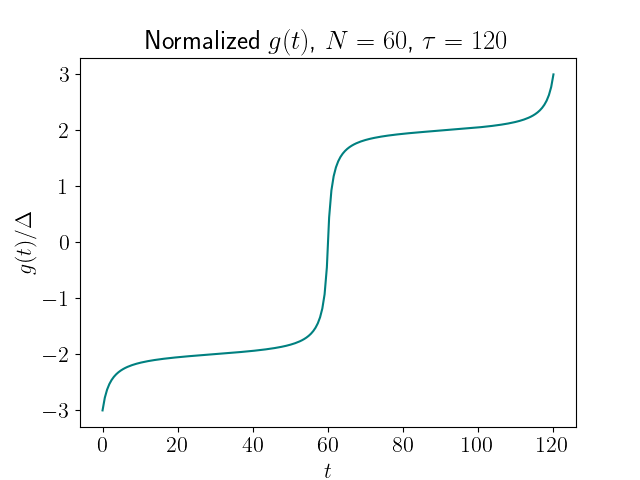

In [20]:
g_values = [g_t(i, gvars)/omega for i in ts]

fig7,ax7=plt.subplots()

# Axes label
ax7.set_xlabel('$t$')
ax7.set_ylabel('$g(t)/ \\Delta$')
ax7.plot(ts, g_values, color='teal')

title7 = "Normalized $ g(t) $, $ N={} $, ".format(int(npart)) + "$ \\tau={} $".format(int(tau))
ax7.set_title(title7)